# Dependencies

In [ ]:
#%%writefile train.py
# Block 1: Importing all necessary dependencies
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# PyTorch and torchvision libraries for data handling and transforms
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

# For visualization in Google Colab (if you're using it)
from google.colab.patches import cv2_imshow

# Optionally, if you wish to clone the repo via Git in your script:
import subprocess



# Loading the Dataset

Dataset directories: ['with_mask', 'without_mask']


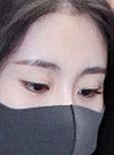

Label for 'with_mask': 0


In [ ]:
# Block 2: Clone the GitHub repo and visualize a sample image
# We'll clone the full repo and then use the dataset folder

# Cloning using subprocess (this works in a notebook environment)
repo_url = "https://github.com/chandrikadeb7/Face-Mask-Detection.git"
subprocess.run(["git", "clone", repo_url])

# Define the dataset directory (the repo contains a 'dataset' folder)
dataset_dir = os.path.join("Face-Mask-Detection", "dataset")
print("Dataset directories:", os.listdir(dataset_dir))

# Assume two folders: 'with_mask' and 'without_mask'
# For our assignment, we assign: with_mask -> label 0, without_mask -> label 1

# Visualize a sample image from the 'with_mask' folder:
with_mask_dir = os.path.join(dataset_dir, "with_mask")
sample_img_name = os.listdir(with_mask_dir)[0]
sample_img_path = os.path.join(with_mask_dir, sample_img_name)

# Read and display the image using cv2_imshow
sample_img = cv2.imread(sample_img_path)
cv2_imshow(sample_img)
print("Label for 'with_mask': 0")


In [ ]:
import os
print(len(os.listdir('/content/Face-Mask-Detection/dataset/without_mask')))

1930


In [ ]:
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models

!git clone https://github.com/chandrikadeb7/Face-Mask-Detection.git

def extract_hog_features(image_path, target_size=(50, 50)):
    """Extracts HOG features from a downsampled image."""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, target_size)
    features, hog_image = hog(img_resized, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return features, hog_image

data_dir = "/content/Face-Mask-Detection/dataset"  # Replace with the actual path to your dataset
features_list = []
labels_list = []
image_count = 0

# Collect 10 image paths for HOG visualization
image_paths_for_hog = []
labels_for_hog = []
hog_visualization_count = 0

for class_name in ["with_mask", "without_mask"]:
    class_dir = os.path.join(data_dir, class_name)
    for filename in os.listdir(class_dir):
        if filename.endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(class_dir, filename)
            features, hog_image = extract_hog_features(image_path)
            features_list.append(features)
            labels_list.append(class_name)
            image_count += 1

            # Collect images for HOG visualization
            if hog_visualization_count < 10:
                image_paths_for_hog.append(image_path)
                labels_for_hog.append(class_name)
                hog_visualization_count += 1

            if image_count % 1000 == 0:
                print(f"Processed {image_count} images...")

print(f"Total images processed: {image_count}")

# Display HOG features for 10 images
plt.figure(figsize=(15, 5 * len(image_paths_for_hog)))  # Adjust figure size as needed
for i, image_path in enumerate(image_paths_for_hog):
    features, hog_image = extract_hog_features(image_path)

    # Display original image
    plt.subplot(len(image_paths_for_hog), 2, 2 * i + 1)
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
    plt.imshow(original_image)
    plt.title(f"Original Image: {labels_for_hog[i]}")
    plt.axis('off')

    # Display HOG image
    plt.subplot(len(image_paths_for_hog), 2, 2 * i + 2)
    plt.imshow(hog_image, cmap="gray")
    plt.title("HOG Features")
    plt.axis('off')

    # Print feature vector shape
    print(f"Image {i+1} HOG Feature Vector Shape: {features.shape}")

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

X = np.array(features_list)
y = np.array([1 if label == "with_mask" else 0 for label in labels_list])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train SVM
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("\nSVM Accuracy:", accuracy_svm)
print(classification_report(y_test, y_pred_svm))

# Train Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("\nRandom Forest Accuracy:", accuracy_rf)
print(classification_report(y_test, y_pred_rf))

# Train Neural Network (CNN)
model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), verbose=0)

# Evaluate Neural Network
loss, accuracy_nn = model.evaluate(X_test, y_test)
print(f"\nNeural Network Accuracy: {accuracy_nn}")

#Generate Classification Report.
y_pred_proba_nn = model.predict(X_test)
y_pred_nn = (y_pred_proba_nn > 0.5).astype(int)
print(classification_report(y_test, y_pred_nn))

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.show()

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# ... (Your existing code for loading data, preprocessing, and training the models) ...

# Assuming 'model' is your trained neural network model
# and 'svm_classifier' is your trained SVM model
# and X_test, y_test are already defined.

def preprocess_image(image_path, target_size=(50, 50)): # Add target_size
    """Preprocesses a single image for prediction using HOG features."""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, target_size)
    features, hog_image = hog(img_resized, pixels_per_cell=(8, 8),
                             cells_per_block=(2, 2), visualize=True)
    return features.reshape(1, -1)  # Reshape for model prediction

def predict_mask(image_path, model_type="nn"):
    """Predicts if an image has a mask using the specified model."""
    img_processed = preprocess_image(image_path)

    if model_type == "nn":
        prediction = model.predict(img_processed)
        if prediction[0][0] > 0.5:
            return "With Mask"
        else:
            return "Without Mask"
    elif model_type == "svm":
        prediction = svm_classifier.predict(img_processed)
        if prediction[0] == 1:
            return "With Mask"
        else:
            return "Without Mask"
    else:
        return "Invalid model type. Please choose 'nn' or 'svm'."

# Interactive Prediction Loop
while True:
    image_path = input("Enter the image path (or type 'exit' to quit): ")
    if image_path.lower() == "exit":
        break

    model_choice = input("Enter 'nn' for neural network or 'svm' for SVM: ").lower()
    prediction_result = predict_mask(image_path, model_choice)

    print(f"Prediction: {prediction_result}")

Enter the image path (or type 'exit' to quit): /content/Face-Mask-Detection/dataset/without_mask/0_0_aidai_0029.jpg
Enter 'nn' for neural network or 'svm' for SVM: nn
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Prediction: Without Mask
Enter the image path (or type 'exit' to quit): /content/Face-Mask-Detection/dataset/without_mask/0_0_aidai_0029.jpg
Enter 'nn' for neural network or 'svm' for SVM: svm
Prediction: Without Mask
Enter the image path (or type 'exit' to quit): exit


# Data Preprocessing

In [ ]:
import os
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Function to gather image paths and assign labels based on folder names
def get_data(dataset_dir, label_map):
    data = []
    for folder, label in label_map.items():
        folder_path = os.path.join(dataset_dir, folder)
        for img_file in os.listdir(folder_path):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                data.append((os.path.join(folder_path, img_file), label))
    return data

# Function to split data into train, validation, and test sets
def split_data(data, train_ratio=0.7, val_ratio=0.15):
    np.random.shuffle(data)
    total = len(data)
    n_train = int(train_ratio * total)
    n_val = int(val_ratio * total)
    train_data = data[:n_train]
    val_data = data[n_train:n_train+n_val]
    test_data = data[n_train+n_val:]
    return train_data, val_data, test_data

# Custom PyTorch Dataset class
class FaceMaskDataset(Dataset):
    def __init__(self, data_list, transform=None):
        """
        data_list: List of tuples (image_path, label)
        transform: PyTorch transforms to be applied on the image
        """
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_path, label = self.data_list[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Specify the dataset directory and label mapping
dataset_dir = "Face-Mask-Detection/dataset"  # Update this path if necessary
label_map = {"with_mask": 0, "without_mask": 1}

# Gather the data and report total count
data = get_data(dataset_dir, label_map)
print("Total images found:", len(data))

# Split data into training, validation, and test sets
train_data, val_data, test_data = split_data(data, train_ratio=0.7, val_ratio=0.15)
print("Train samples:", len(train_data),
      "Validation samples:", len(val_data),
      "Test samples:", len(test_data))

# Use the provided mean and std values
dataset_mean = [0.5765, 0.4986, 0.4681]
dataset_std = [0.2565, 0.2422, 0.2338]

# Define final transformation with normalization
final_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std)
])

# Create final datasets using the transformation
train_dataset = FaceMaskDataset(train_data, transform=final_transform)
val_dataset = FaceMaskDataset(val_data, transform=final_transform)
test_dataset = FaceMaskDataset(test_data, transform=final_transform)

# Function to create DataLoaders with a given batch_size (modular for hyperparameter tuning)
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=32):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

# Set batch_size as a variable (to be tuned via hyperparameters later)
batch_size = 32
train_loader, val_loader, test_loader = create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=batch_size)

print("DataLoaders are ready for training, validation, and testing.")


Total images found: 4092
Train samples: 2864 Validation samples: 613 Test samples: 615
DataLoaders are ready for training, validation, and testing.


In [ ]:
import torch
import torch.nn as nn

# Utility function to return the desired activation module for hidden layers.
def get_activation_fn(activation_str):
    if activation_str.lower() == "relu":
        return nn.ReLU(inplace=True)
    elif activation_str.lower() == "leakyrelu":
        return nn.LeakyReLU(inplace=True)
    elif activation_str.lower() == "sigmoid":
        return nn.Sigmoid()  # For hidden layers if desired (though not common)
    elif activation_str.lower() == "tanh":
        return nn.Tanh()
    else:
        raise ValueError(f"Unsupported activation function: {activation_str}")

# Define a Residual Block with skip connections that accepts a dynamic activation function.
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, activation_str="relu"):
        super(ResidualBlock, self).__init__()
        self.activation_fn = get_activation_fn(activation_str)
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Downsampling layer if needed to match dimensions for the skip connection
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation_fn(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        # Add the skip connection and apply the activation function again.
        out += identity
        out = self.activation_fn(out)
        return out

# Define the CNN model with skip connections (a mini ResNet) and modular hyperparameters.
# This model uses the chosen activation function (e.g., tanh) for all hidden layers.
# The final classification layer does not apply an activation so that during training,
# BCEWithLogitsLoss can be used. For inference, you can apply sigmoid externally if needed.
class SimpleResNet(nn.Module):
    def __init__(self, num_classes=1, base_channels=16, activation_str="relu", num_blocks=[2, 2, 2]):
        """
        num_classes: Number of output classes (use 1 for binary classification)
        base_channels: Number of channels in the initial conv layer
        activation_str: Activation function to use in hidden layers (e.g., "relu", "leakyrelu", "sigmoid", "tanh")
        num_blocks: A list defining the number of residual blocks in each layer.
                    For example, [2, 2, 2] creates three layers with 2 blocks each.
        """
        super(SimpleResNet, self).__init__()
        self.activation_str = activation_str
        self.activation_fn = get_activation_fn(activation_str)
        self.base_channels = base_channels

        # Initial convolutional layer
        self.conv = nn.Conv2d(3, base_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(base_channels)

        # Create residual layers:
        # Layer 1: from base_channels to base_channels
        self.layer1 = self._make_layer(ResidualBlock, in_channels=base_channels, out_channels=base_channels,
                                       blocks=num_blocks[0], stride=1)
        # Layer 2: from base_channels to base_channels * 2
        self.layer2 = self._make_layer(ResidualBlock, in_channels=base_channels, out_channels=base_channels*2,
                                       blocks=num_blocks[1], stride=2)
        # Layer 3: from base_channels * 2 to base_channels * 4
        self.layer3 = self._make_layer(ResidualBlock, in_channels=base_channels*2, out_channels=base_channels*4,
                                       blocks=num_blocks[2], stride=2)

        # Global average pooling and final fully-connected layer.
        # Note: We do not apply an activation here so that BCEWithLogitsLoss can be used.
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(base_channels * 4, num_classes)

    def _make_layer(self, block, in_channels, out_channels, blocks, stride):
        layers = []
        # First block with potential downsampling.
        layers.append(block(in_channels, out_channels, stride, activation_str=self.activation_str))
        # Subsequent blocks.
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels, activation_str=self.activation_str))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial conv, batch norm, and activation.
        out = self.conv(x)
        out = self.bn(out)
        out = self.activation_fn(out)

        # Pass through residual layers.
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        # Global average pooling, flatten, and classification.
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

# Testing the modified model with a dummy input to ensure it works correctly.
if __name__ == "__main__":
    # For experimentation, you can change the activation_str to "tanh".
    model = SimpleResNet(num_classes=1, base_channels=16, activation_str="tanh", num_blocks=[2, 2, 2])
    dummy_input = torch.randn(1, 3, 256, 256)
    output = model(dummy_input)
    print("Model output shape:", output.shape)



Model output shape: torch.Size([1, 1])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import wandb
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

def train(config_defaults):
    wandb.init(project="face_mask_detection", config=config_defaults)
    config = wandb.config

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    train_loader, val_loader, test_loader = create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=config.batch_size)

    model = SimpleResNet(num_classes=1, base_channels=config.base_channels, activation_str=config.activation_fn, num_blocks=config.num_blocks)
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay) if config.optimizer.lower() == "adam" else optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9, weight_decay=config.weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True) if config.use_scheduler else None

    best_val_loss = float('inf')
    train_losses, val_losses = [], []

    for epoch in range(config.epochs):
        model.train()
        running_train_loss, correct_train, total_train = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_train_loss / len(train_loader.dataset)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)

        model.eval()
        running_val_loss, correct_val, total_val = 0.0, 0, 0
        correct_class0, total_class0, correct_class1, total_class1 = 0, 0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
                preds = (torch.sigmoid(outputs) >= 0.5).float()
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)
                mask_class0, mask_class1 = (labels == 0), (labels == 1)
                total_class0 += mask_class0.sum().item()
                total_class1 += mask_class1.sum().item()
                correct_class0 += ((preds == 0) & mask_class0).sum().item()
                correct_class1 += ((preds == 1) & mask_class1).sum().item()

        val_loss = running_val_loss / len(val_loader.dataset)
        val_accuracy = correct_val / total_val
        class0_accuracy = correct_class0 / total_class0 if total_class0 > 0 else 0
        class1_accuracy = correct_class1 / total_class1 if total_class1 > 0 else 0
        val_losses.append(val_loss)

        wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss, "train_accuracy": train_accuracy, "val_accuracy": val_accuracy, "val_class0_accuracy": class0_accuracy, "val_class1_accuracy": class1_accuracy})
        print(f"Epoch {epoch+1}/{config.epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print(f"Saving new best model with validation loss: {val_loss:.4f}")

        if scheduler:
            scheduler.step(val_loss)

    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss vs Epoch")
    plt.savefig("loss_curve.png")
    wandb.log({"loss_curve": wandb.Image("loss_curve.png")})
    plt.close()

    # --- Test Evaluation ---
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    running_test_loss, correct_test, total_test = 0.0, 0, 0
    correct_class0, total_class0, correct_class1, total_class1 = 0, 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)
            mask_class0, mask_class1 = (labels == 0), (labels == 1)
            total_class0 += mask_class0.sum().item()
            total_class1 += mask_class1.sum().item()
            correct_class0 += ((preds == 0) & mask_class0).sum().item()
            correct_class1 += ((preds == 1) & mask_class1).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_test_loss / len(test_loader.dataset)
    test_accuracy = correct_test / total_test
    test_class0_accuracy = correct_class0 / total_class0 if total_class0 > 0 else 0
    test_class1_accuracy = correct_class1 / total_class1 if total_class1 > 0 else 0

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Class 0 Accuracy: {test_class0_accuracy:.4f}, Test Class 1 Accuracy: {test_class1_accuracy:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Mask", "Mask"], yticklabels=["No Mask", "Mask"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.savefig("confusion_matrix.png")
    wandb.log({"confusion_matrix": wandb.Image("confusion_matrix.png")})
    plt.close()


In [ ]:

config_defaults = {
        "learning_rate": 0.001,
        "batch_size": 32,
        "optimizer": "adam",          # Options: "adam", "sgd", etc.
        "activation_fn": "relu",        # Options: "relu", "leakyrelu", "sigmoid", etc.
        "base_channels": 16,            # Base number of channels for the model.
        "num_blocks": [2, 2, 2],        # Number of residual blocks in each layer.
        "epochs": 20,
        "patience": 5,                # Early stopping patience.
        "weight_decay": 1e-4,
        "use_scheduler": True,        # Whether to use a learning rate scheduler.
        # Additional hyperparameters such as dropout rate, kernel size, etc. can be added here.
    }
train(config_defaults)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: saishruti-prakhya018 (saishruti-prakhya018-international-institute-of-informat) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using device: cuda:0


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/20 - Train Loss: 0.4830, Val Loss: 0.5176, Train Acc: 0.7730, Val Acc: 0.7716
Saving new best model with validation loss: 0.5176
Epoch 2/20 - Train Loss: 0.4397, Val Loss: 0.5339, Train Acc: 0.8059, Val Acc: 0.7602
Epoch 3/20 - Train Loss: 0.4377, Val Loss: 0.4857, Train Acc: 0.8027, Val Acc: 0.7896
Saving new best model with validation loss: 0.4857
Epoch 4/20 - Train Loss: 0.4275, Val Loss: 0.5006, Train Acc: 0.8198, Val Acc: 0.7896
Epoch 5/20 - Train Loss: 0.4262, Val Loss: 0.5552, Train Acc: 0.8167, Val Acc: 0.6900
Epoch 6/20 - Train Loss: 0.4037, Val Loss: 0.4383, Train Acc: 0.8268, Val Acc: 0.8026
Saving new best model with validation loss: 0.4383
Epoch 7/20 - Train Loss: 0.3873, Val Loss: 0.5314, Train Acc: 0.8408, Val Acc: 0.7602
Epoch 8/20 - Train Loss: 0.3868, Val Loss: 0.5808, Train Acc: 0.8394, Val Acc: 0.7586
Epoch 9/20 - Train Loss: 0.3578, Val Loss: 0.3826, Train Acc: 0.8537, Val Acc: 0.8385
Saving new best model with validation loss: 0.3826
Epoch 10/20 - Train Lo

In [ ]:

config_defaults = {
        "learning_rate": 0.001,
        "batch_size": 32,
        "optimizer": "adam",          # Options: "adam", "sgd", etc.
        "activation_fn": "leakyrelu",        # Options: "relu", "leakyrelu", "sigmoid", etc.
        "base_channels": 16,            # Base number of channels for the model.
        "num_blocks": [2, 2, 2],        # Number of residual blocks in each layer.
        "epochs": 50,
        "patience": 5,                # Early stopping patience.
        "weight_decay": 1e-4,
        "use_scheduler": True,        # Whether to use a learning rate scheduler.
        # Additional hyperparameters such as dropout rate, kernel size, etc. can be added here.
    }
train(config_defaults)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: saishruti-prakhya018 (saishruti-prakhya018-international-institute-of-informat) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using device: cuda:0


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/50 - Train Loss: 0.4938, Val Loss: 0.6391, Train Acc: 0.7587, Val Acc: 0.7031
Saving new best model with validation loss: 0.6391
Epoch 2/50 - Train Loss: 0.4506, Val Loss: 0.6683, Train Acc: 0.7978, Val Acc: 0.7243
Epoch 3/50 - Train Loss: 0.4315, Val Loss: 0.6096, Train Acc: 0.8083, Val Acc: 0.7374
Saving new best model with validation loss: 0.6096
Epoch 4/50 - Train Loss: 0.4331, Val Loss: 0.5227, Train Acc: 0.8142, Val Acc: 0.7716
Saving new best model with validation loss: 0.5227
Epoch 5/50 - Train Loss: 0.4143, Val Loss: 0.5329, Train Acc: 0.8223, Val Acc: 0.7455
Epoch 6/50 - Train Loss: 0.4113, Val Loss: 0.5220, Train Acc: 0.8289, Val Acc: 0.7569
Saving new best model with validation loss: 0.5220
Epoch 7/50 - Train Loss: 0.3906, Val Loss: 0.4463, Train Acc: 0.8380, Val Acc: 0.8124
Saving new best model with validation loss: 0.4463
Epoch 8/50 - Train Loss: 0.3651, Val Loss: 0.4659, Train Acc: 0.8499, Val Acc: 0.8026
Epoch 9/50 - Train Loss: 0.3519, Val Loss: 0.5356, Train 

In [ ]:
config_defaults = {
        "learning_rate": 0.01,
        "batch_size": 16,
        "optimizer": "sgd",          # Options: "adam", "sgd", etc.
        "activation_fn": "leakyrelu",        # Options: "relu", "leakyrelu", "sigmoid", etc.
        "base_channels": 16,            # Base number of channels for the model.
        "num_blocks": [2, 2, 2],        # Number of residual blocks in each layer.
        "epochs": 50,
        "patience": 5,                # Early stopping patience.
        "weight_decay": 1e-4,
        "use_scheduler": False,        # Whether to use a learning rate scheduler.
        # Additional hyperparameters such as dropout rate, kernel size, etc. can be added here.
    }
train(config_defaults)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: saishruti-prakhya018 (saishruti-prakhya018-international-institute-of-informat) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using device: cuda:0


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/50 - Train Loss: 0.5385, Val Loss: 0.6229, Train Acc: 0.7444, Val Acc: 0.7129
Saving new best model with validation loss: 0.6229
Epoch 2/50 - Train Loss: 0.5083, Val Loss: 0.9287, Train Acc: 0.7685, Val Acc: 0.6917
Epoch 3/50 - Train Loss: 0.4923, Val Loss: 0.5636, Train Acc: 0.7699, Val Acc: 0.6868
Saving new best model with validation loss: 0.5636
Epoch 4/50 - Train Loss: 0.4554, Val Loss: 0.6639, Train Acc: 0.7919, Val Acc: 0.6639
Epoch 5/50 - Train Loss: 0.4637, Val Loss: 0.4362, Train Acc: 0.7926, Val Acc: 0.7945
Saving new best model with validation loss: 0.4362
Epoch 6/50 - Train Loss: 0.4471, Val Loss: 0.4150, Train Acc: 0.8038, Val Acc: 0.7977
Saving new best model with validation loss: 0.4150
Epoch 7/50 - Train Loss: 0.4173, Val Loss: 0.4148, Train Acc: 0.8251, Val Acc: 0.8157
Saving new best model with validation loss: 0.4148
Epoch 8/50 - Train Loss: 0.4129, Val Loss: 0.3971, Train Acc: 0.8261, Val Acc: 0.8483
Saving new best model with validation loss: 0.3971
Epoch 

In [ ]:
config_defaults = {
        "learning_rate": 0.001,
        "batch_size": 16,
        "optimizer": "adam",          # Options: "adam", "sgd", etc.
        "activation_fn": "sigmoid",        # Options: "relu", "leakyrelu", "sigmoid", etc.
        "base_channels": 16,            # Base number of channels for the model.
        "num_blocks": [2, 2, 2],        # Number of residual blocks in each layer.
        "epochs": 50,
        "patience": 5,                # Early stopping patience.
        "weight_decay": 1e-4,
        "use_scheduler": False,        # Whether to use a learning rate scheduler.
        # Additional hyperparameters such as dropout rate, kernel size, etc. can be added here.
    }
train(config_defaults)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: saishruti-prakhya018 (saishruti-prakhya018-international-institute-of-informat) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using device: cuda:0


KeyboardInterrupt: 

In [ ]:
config_defaults = {
        "learning_rate": 0.001,
        "batch_size": 32,
        "optimizer": "adam",          # Options: "adam", "sgd", etc.
        "activation_fn": "tanh",        # Options: "relu", "leakyrelu", "sigmoid", etc.
        "base_channels": 16,            # Base number of channels for the model.
        "num_blocks": [2, 2, 2],        # Number of residual blocks in each layer.
        "epochs": 50,
        "patience": 5,                # Early stopping patience.
        "weight_decay": 1e-4,
        "use_scheduler": True,        # Whether to use a learning rate scheduler.
        # Additional hyperparameters such as dropout rate, kernel size, etc. can be added here.
    }
train(config_defaults)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: saishruti-prakhya018 (saishruti-prakhya018-international-institute-of-informat) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using device: cuda:0


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/50 - Train Loss: 0.5131, Val Loss: 0.5462, Train Acc: 0.7483, Val Acc: 0.7602
Saving new best model with validation loss: 0.5462
Epoch 2/50 - Train Loss: 0.4941, Val Loss: 0.5599, Train Acc: 0.7689, Val Acc: 0.7455
Epoch 3/50 - Train Loss: 0.4700, Val Loss: 0.4669, Train Acc: 0.7807, Val Acc: 0.7749
Saving new best model with validation loss: 0.4669
Epoch 4/50 - Train Loss: 0.4653, Val Loss: 0.4198, Train Acc: 0.7909, Val Acc: 0.8140
Saving new best model with validation loss: 0.4198
Epoch 5/50 - Train Loss: 0.4468, Val Loss: 0.4154, Train Acc: 0.7950, Val Acc: 0.8352
Saving new best model with validation loss: 0.4154
Epoch 6/50 - Train Loss: 0.4428, Val Loss: 0.5486, Train Acc: 0.8083, Val Acc: 0.7390
Epoch 7/50 - Train Loss: 0.4493, Val Loss: 0.4445, Train Acc: 0.7968, Val Acc: 0.8108
Epoch 8/50 - Train Loss: 0.4248, Val Loss: 0.5297, Train Acc: 0.8167, Val Acc: 0.7080
Epoch 9/50 - Train Loss: 0.3976, Val Loss: 0.8979, Train Acc: 0.8373, Val Acc: 0.5041
Epoch 10/50 - Train Lo

In [ ]:
config_defaults = {
        "learning_rate": 0.01,
        "batch_size": 32,
        "optimizer": "sgd",          # Options: "adam", "sgd", etc.
        "activation_fn": "tanh",        # Options: "relu", "leakyrelu", "sigmoid", etc.
        "base_channels": 16,            # Base number of channels for the model.
        "num_blocks": [2, 2, 2],        # Number of residual blocks in each layer.
        "epochs": 50,
        "patience": 5,                # Early stopping patience.
        "weight_decay": 1e-4,
        "use_scheduler": True,        # Whether to use a learning rate scheduler.
        # Additional hyperparameters such as dropout rate, kernel size, etc. can be added here.
    }
train(config_defaults)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: saishruti-prakhya018 (saishruti-prakhya018-international-institute-of-informat) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using device: cuda:0


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/50 - Train Loss: 0.5414, Val Loss: 0.6291, Train Acc: 0.7469, Val Acc: 0.6966
Saving new best model with validation loss: 0.6291
Epoch 2/50 - Train Loss: 0.5095, Val Loss: 0.7086, Train Acc: 0.7622, Val Acc: 0.6297
Epoch 3/50 - Train Loss: 0.5050, Val Loss: 0.4336, Train Acc: 0.7563, Val Acc: 0.7961
Saving new best model with validation loss: 0.4336
Epoch 4/50 - Train Loss: 0.4868, Val Loss: 0.4800, Train Acc: 0.7825, Val Acc: 0.7716
Epoch 5/50 - Train Loss: 0.4912, Val Loss: 0.4203, Train Acc: 0.7772, Val Acc: 0.8108
Saving new best model with validation loss: 0.4203
Epoch 6/50 - Train Loss: 0.4801, Val Loss: 0.4727, Train Acc: 0.7867, Val Acc: 0.7765
Epoch 7/50 - Train Loss: 0.4868, Val Loss: 0.4318, Train Acc: 0.7818, Val Acc: 0.8091
Epoch 8/50 - Train Loss: 0.4573, Val Loss: 0.4975, Train Acc: 0.8097, Val Acc: 0.7569
Epoch 9/50 - Train Loss: 0.4586, Val Loss: 0.5024, Train Acc: 0.7874, Val Acc: 0.7684
Epoch 10/50 - Train Loss: 0.4198, Val Loss: 0.3720, Train Acc: 0.8244, Va

In [ ]:
!wandb sweep sweep_config.yaml

wandb: Login to W&B to use the sweep feature
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: saishruti-prakhya018 (saishruti-prakhya018-international-institute-of-informat) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Creating sweep from: sweep_config.yaml
wandb: Creating sweep with ID: 46lu8sek
wandb: View sweep at: https://wandb.ai/saishruti-prakhya018-international-institute-of-informat/face_mask_detection/sweeps/46lu8sek
wandb: Run sweep agent with: wandb agent saishruti-prakhya018-international-institute-of-informat/face_mask_detection/46lu8sek


In [ ]:
!wandb agent --count 10 saishruti-prakhya018-international-institute-of-informat/face_mask_detection/46lu8sek

wandb: Starting wandb agent 🕵️
2025-03-17 10:05:39,442 - wandb.wandb_agent - INFO - Running runs: []
2025-03-17 10:05:39,783 - wandb.wandb_agent - INFO - Agent received command: run
2025-03-17 10:05:39,784 - wandb.wandb_agent - INFO - Agent starting run with config:
	activation_fn: leakyrelu
	base_channels: 32
	batch_size: 16
	epochs: 30
	learning_rate: 0.007252211589517256
	optimizer: adam
	patience: 5
	use_scheduler: True
	weight_decay: 0.00019733677006572895
2025-03-17 10:05:39,785 - wandb.wandb_agent - INFO - About to run command: /usr/bin/env python train.py --activation_fn=leakyrelu --base_channels=32 --batch_size=16 --epochs=30 --learning_rate=0.007252211589517256 --optimizer=adam --patience=5 --use_scheduler=True --weight_decay=0.00019733677006572895
fatal: destination path 'Face-Mask-Detection' already exists and is not an empty directory.
Dataset directories: ['without_mask', 'with_mask']
<PIL.Image.Image image mode=RGB size=159x242 at 0x7EB6377F9410>
Label for 'with_mask': 0